In [1]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../deterministic'))
from deterministic.mps import MPS
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [4]:
#generate a random tensor list
qubit_num = 10
bond_dim = 50
tensor_liste = [pt.randn([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [5]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [6]:
idx = [10, 20]
mps.idx_to_visible(idx)

tensor([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [3]:
ratio_h_j = 0.1
qubit_num = 10
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
tensor_liste = mps.tensors

In [4]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-9.030021937875183


In [17]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 12
num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 30
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            probs_direct = MPSQuantumState(qubit_num, tensor_liste).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct) #run this for both probs
        energy = pt.mean(energies)
        energies_different_meas_num[i,b] = energy

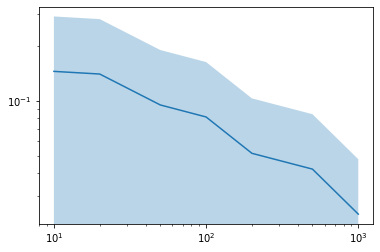

In [20]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')

In [5]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 10
ratio_h_j = 0.1
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.size()[0], dtype=pt.cdouble)

In [3]:
# we estimate the energy exactly by contraction with the hamiltonian
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec = random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.tensor(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)

In [8]:
# now we estimate the gradient by using the classical shadows
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.from_param_vec(param_vec=random_param_vec_shadow)
tensor_liste = mps.tensors
num_of_measurements = 100
num_of_measurements_per_rot = 20
meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
energies = pt.zeros(len(meas_outcomes))
for n in range(len(meas_outcomes)):
    # first get the unique elements of this torch tensor
    unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
    # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
    # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
    # thus we compute the probabilities again, from the tensors directly
    probs_direct = MPSQuantumState(qubit_num, tensor_liste).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
    energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
energy_shadow = pt.mean(energies)

In [9]:
energy.backward()
energy_shadow.backward()
print(energy_shadow)
print(energy)
print(random_param_vec_brute.grad)
print(random_param_vec_shadow.grad)
print(pt.linalg.norm((random_param_vec_brute.grad - random_param_vec_shadow.grad)/pt.linalg.norm(random_param_vec_brute.grad)))
print(pt.linalg.norm(random_param_vec_brute.grad))

tensor(11.0674, grad_fn=<MeanBackward0>)
tensor(9.9869+3.4869e-17j, dtype=torch.complex128, grad_fn=<DivBackward0>)
tensor([ 9.2000e-04+0.0002j,  6.6045e-04+0.0007j,  1.3397e-05-0.0005j,
         ..., -3.7647e-03-0.0005j,  4.4741e-03+0.0014j,
        -4.3349e-03-0.0011j], dtype=torch.complex128)
tensor([-0.0031+0.2147j, -0.0020+0.2369j, -0.0201+0.2078j,  ...,
         0.2120+0.1903j,  0.2356+0.1994j,  0.2039+0.1586j],
       dtype=torch.complex128)
tensor(93.5050, dtype=torch.float64)
tensor(0.0549, dtype=torch.float64)


In [10]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state

In [66]:
# doing gradient descent using pytorch optimizer
step_num = 500
lr = 0.01
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
opt = torch.optim.Adam([random_param_vec_brute], lr=lr)

accuracy = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()

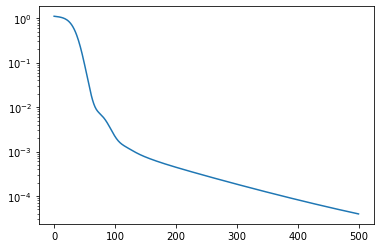

In [68]:
plt.plot(np.arange(0, step_num), accuracy)
plt.yscale('log')

In [ ]:
# doing gradient descent using pytorch optimizer
step_num = 50
lr = 0.01
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
opt = torch.optim.Adam([random_param_vec_shadow], lr=lr)
num_of_measurements = 50
num_of_measurements_per_rot = 30

accuracy = np.zeros(step_num)
for i in range(step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec=random_param_vec_shadow)
    tensor_liste = mps.tensors
    meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
    energies = pt.zeros(len(meas_outcomes))
    for n in range(len(meas_outcomes)):
        # first get the unique elements of this torch tensor
        unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
        # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
        # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
        # thus we compute the probabilities again, from the tensors directly
        probs_direct = MPSQuantumState(qubit_num, tensor_liste).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
        measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
        energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
    energy_shadow = pt.mean(energies)
    energy_shadow.backward()
    accuracy[i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i) + ' / ' + str(step_num))

progress: 0 / 50
progress: 1 / 50


In [ ]:
plt.plot(np.arange(0, step_num), accuracy)

In [9]:
# rewriting the sampling/measure function
# sampling algorithm
def sampling_one_sample(mps, qubit_num):
    #we store the sampled bits and probabilities in here
    bits_sampled = pt.zeros(qubit_num)
    probabilities_for_bits = pt.ones(qubit_num)
    mps.canonicalise(qubit_num - 1)
    #we only need to do this step if the MPS is not normalised
    part_func = mps.norm()
    #contract the network
    for idx_rev in range(qubit_num - 1, -1, -1):
        if idx_rev==qubit_num-1:
            result = pt.einsum('ijl,iml->jm', mps.tensors[idx_rev], mps.tensors[idx_rev].conj())
        else:
            #fixing already sampled indices of visibles from here
            result = pt.einsum('fh,jh->fj', mps.tensors[qubit_num-1][:,int(bits_sampled[qubit_num-1].item()),:], mps.tensors[qubit_num-1][:,int(bits_sampled[qubit_num-1].item()),:].conj())
            for counter_rev in range(qubit_num - 2, idx_rev, -1):
                # Left -> Right
                result = pt.einsum('fj,df->dj', result, mps.tensors[counter_rev][:,int(bits_sampled[counter_rev].item()),:])
                # Top -> Bottom
                result = pt.einsum('dj,lj->dl', result, mps.tensors[counter_rev][:,int(bits_sampled[counter_rev].item()),:].conj())
            # indices of visibles not fixed anymore
            result = pt.einsum('rs,acr->acs', result, mps.tensors[idx_rev])
            result = pt.einsum('acs,ams->cm', result, mps.tensors[idx_rev].conj())
    #contraction done
        prob_for_previous_bits = pt.prod(probabilities_for_bits, dim=0)
        probs = [(pt.abs(result[0,0])/part_func)/prob_for_previous_bits, (pt.abs(result[1,1])/part_func)/prob_for_previous_bits]
        bits_sampled[idx_rev] = pt.multinomial(pt.tensor([probs[0].real.item(), probs[1].real.item()]), 1, replacement=True)[0].item()
        probabilities_for_bits[idx_rev] = probs[int(bits_sampled[idx_rev].item())]
    print(bits_sampled)
    return mps.visible_to_idx(bits_sampled), pt.prod(probabilities_for_bits)

In [14]:
ratio_h_j = 0.1
qubit_num = 10
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
meas_bases = randomized_classical_shadow(1, qubit_num)
#mps = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_bases[0]).mps
index_sampled, prob = sampling_one_sample(mps, qubit_num)
print(index_sampled, prob)

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor(341, dtype=torch.int32) tensor(0.4950)


In [62]:
prob_direct = MPSQuantumState(qubit_num, mps).prob(pt.tensor([index_sampled.item(), 1]))
print(prob_direct)

tensor([0.0042+0.j, 0.0031+0.j], dtype=torch.complex128)
